In [1]:
import os
import numpy as np
import cv2
#np.warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
from tqdm import tqdm

from google_drive_downloader import GoogleDriveDownloader as gdd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
#from tensorflow.contrib.eager.python import tfe
from PIL import Image

#tf.enable_eager_execution()
#tf.set_random_seed(0)
np.random.seed(0)

In [7]:
!unzip /content/drive/MyDrive/fc-cnn-assignment.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/images/VietAI-Assignment3-550.jpg  
  inflating: images/images/VietAI-Assignment3-5500.jpg  
  inflating: images/images/VietAI-Assignment3-5501.jpg  
  inflating: images/images/VietAI-Assignment3-5502.jpg  
  inflating: images/images/VietAI-Assignment3-5503.jpg  
  inflating: images/images/VietAI-Assignment3-5504.jpg  
  inflating: images/images/VietAI-Assignment3-5505.jpg  
  inflating: images/images/VietAI-Assignment3-5506.jpg  
  inflating: images/images/VietAI-Assignment3-5507.jpg  
  inflating: images/images/VietAI-Assignment3-5508.jpg  
  inflating: images/images/VietAI-Assignment3-5509.jpg  
  inflating: images/images/VietAI-Assignment3-551.jpg  
  inflating: images/images/VietAI-Assignment3-5510.jpg  
  inflating: images/images/VietAI-Assignment3-5511.jpg  
  inflating: images/images/VietAI-Assignment3-5512.jpg  
  inflating: images/images/VietAI-Assignment3-5513.jpg  
  inflating: images/images/VietAI-Assig

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train_df = pd.read_csv('/content/train.csv')
train_df.head()

,image,label
0,VietAI-Assignment3-1.jpg,7
1,VietAI-Assignment3-100.jpg,2
2,VietAI-Assignment3-10000.jpg,1
3,VietAI-Assignment3-10001.jpg,2
4,VietAI-Assignment3-10002.jpg,2


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8234 entries, 0 to 8233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   8234 non-null   object
 1   label   8234 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 128.8+ KB


In [13]:
test_df = pd.read_csv(os.path.join('/content/sample_submission.csv'))
test_df.head()

,image,label
0,VietAI-Assignment3-10.jpg,0
1,VietAI-Assignment3-1000.jpg,0
2,VietAI-Assignment3-10004.jpg,0
3,VietAI-Assignment3-10006.jpg,0
4,VietAI-Assignment3-10012.jpg,0


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   2059 non-null   object
 1   label   2059 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.3+ KB


Neu

In [15]:

class Dataset:
    def __init__(self, data, label):
        self.data = data
        self.label = label
        self.w = 224
        self.h = 224

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):

        image = cv2.imread(self.data[i])


        image = cv2.resize(image, (self.w, self.h))
        image = np.array(image, dtype='float32')/255
        label = self.label[i]  # Chỉnh sửa: Lấy nhãn tương ứng với ảnh

        return image, label


In [16]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.size = size

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = min((i + 1) * self.batch_size, len(self.dataset))  # Chỉnh sửa: Xử lý chỉ mục kết thúc
        data = [self.dataset[j] for j in range(start, stop)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)

    def __len__(self):
        return (self.size + self.batch_size - 1) // self.batch_size  # Chỉnh sửa: Tính toán số lượng batch


In [27]:
# List các đường dẫn file cho việc huấn luyện
train_files = [os.path.join("/content/images/images", file) for file in train_df.image]

# List các nhãn
train_y = train_df.label
test_files = [os.path.join("/content/images/images", file) for file in test_df.image]
test_y = test_df.label


In [28]:

num_classes = len(np.unique(train_y))
y_ohe = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)
y_test_true = tf.keras.utils.to_categorical(test_y, num_classes=num_classes)

In [19]:

x_train, x_valid, y_train_ohe, y_valid_ohe = train_test_split(train_files, y_ohe, test_size=0.25)


In [20]:
train_dataset = Dataset(x_train, y_train_ohe)
valid_dataset = Dataset(x_valid,y_valid_ohe)
train_loader = Dataloader(train_dataset, 64, len(train_dataset))
valid_loader = Dataloader(valid_dataset, 64, len(valid_dataset))


In [21]:
class ConvBlock(tf.keras.Model):
    def __init__(self, filters, kernel, strides, padding):
        '''
        Khởi tạo Convolution Block với các tham số đầu vào

        Parameters
        ----------
        filters: int
            số lượng filter
        kernel: int
            kích thước kernel
        strides: int
            stride của convolution layer
        padding: str
            Loại padding của convolution layer

        '''
        initializer = tf.keras.initializers.GlorotNormal()
        super(ConvBlock, self).__init__()
        ## TODO 2
        ### START CODE HERE
        self.cnn = tf.keras.layers.Conv2D(filters, kernel, strides=strides,  padding=padding, activation = 'relu', kernel_initializer= initializer)


        ### END CODE HERE


    def call(self, inputs):
        '''
        Hàm này sẽ được gọi trong quá trình forwarding của mạng

        Parameters
        ----------
        inputs: tensor đầu vào

        Returns
        -------
        tensor
            giá trị đầu ra của mạng
        '''


        ## TODO 3
        ### START CODE HERE
        x = self.cnn(inputs)


        ## END CODE HERE

        return x

In [ ]:
# Alex-Net model

In [22]:
class Alex_net(tf.keras.Model):
    def __init__(self, num_classes):

        super(Alex_net, self).__init__()


        ## TODO 4
        ### START CODE HERE
        self.conv1 =  ConvBlock(96,(11,11),4,'valid')
        self.conv2 =  ConvBlock(256,(5,5),1,'same')
        self.conv3 =  ConvBlock(384,(3,3),1,'same')
        self.conv4 =  ConvBlock(384,(3,3),1,'same')
        self.conv5 =  ConvBlock(256,(3,3),1,'same')

        ### END CODE HERE

        ## TODO 5
        ### START CODE HERE
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=2, data_format= None,padding='valid')
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=2, data_format= None,padding='valid')
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=2, data_format= None,padding='valid')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(4096, activation = 'relu')
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(4096, activation = 'relu')
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.fc3 = tf.keras.layers.Dense(1000,activation = 'relu')
        self.fc4 = tf.keras.layers.Dense(num_classes, activation = 'softmax')

        ### END CODE HERE

    def call(self, inputs):

        ## TODO 6
        x = inputs

        ### START CODE HERE
        x = self.conv1(x)
        x= self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x= self.pool3(x)

        ### END CODE HERE

        ## TODO 7
        ### START CODE HERE

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.dropout2(x)
        x= self.fc3(x)
        x = self.fc4(x)
        ### END CODE HERE

        # Để sử dụng hàm softmax, ta phải thực thi trên CPU



        return x

In [23]:
device =  '/gpu:0'

import tensorflow
with tf.device(device):
    # Khởi tạo model
    model = Alex_net(num_classes)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer= tf.optimizers.SGD(learning_rate=0.001,\
                momentum=0.9,weight_decay=0.0005), metrics=['accuracy'])
    # Huấn luyện

    history=model.fit(train_loader, validation_data=valid_loader, epochs=100, verbose=1)
    model.save('my_model', save_format='tf')

Epoch 1/100
97/97 [==============================] - 63s 519ms/step - loss: 2.3328 - accuracy: 0.2170 - val_loss: 2.2972 - val_accuracy: 0.2317
Epoch 2/100
97/97 [==============================] - 63s 657ms/step - loss: 2.2777 - accuracy: 0.2384 - val_loss: 2.2781 - val_accuracy: 0.2317
Epoch 3/100
97/97 [==============================] - 56s 578ms/step - loss: 2.2489 - accuracy: 0.2384 - val_loss: 2.2225 - val_accuracy: 0.2317
Epoch 4/100
97/97 [==============================] - 62s 645ms/step - loss: 2.1573 - accuracy: 0.2555 - val_loss: 2.0983 - val_accuracy: 0.2710
Epoch 5/100
97/97 [==============================] - 52s 534ms/step - loss: 2.0906 - accuracy: 0.2782 - val_loss: 2.0351 - val_accuracy: 0.3181
Epoch 6/100
97/97 [==============================] - 43s 440ms/step - loss: 2.0372 - accuracy: 0.3014 - val_loss: 2.0171 - val_accuracy: 0.3307
Epoch 7/100
97/97 [==============================] - 49s 506ms/step - loss: 2.0004 - accuracy: 0.3161 - val_loss: 1.9816 - val_accuracy:

0.9915789365768433
0.8105876445770264
0.030575944110751152
0.8623624444007874


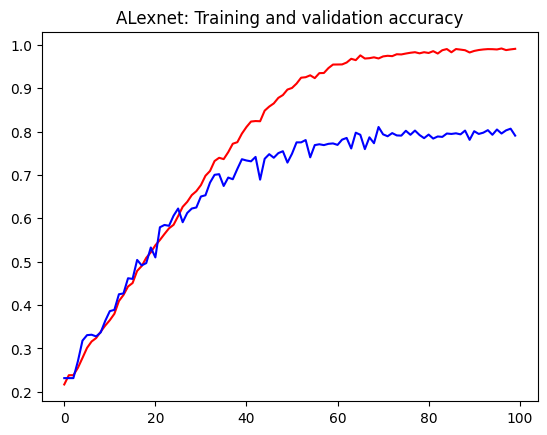

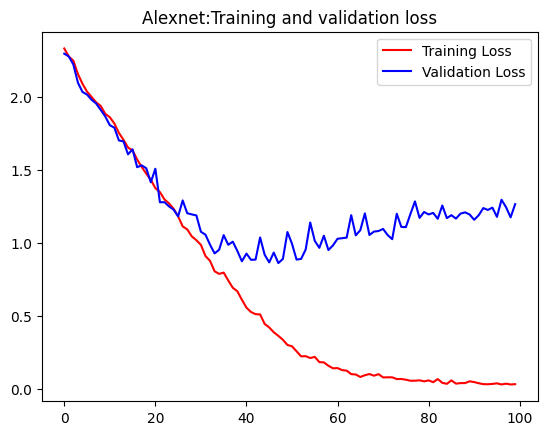

In [24]:
# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
print(max(acc))
print(max(val_acc))
print(min(loss))
print(min(val_loss))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('ALexnet: Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Alexnet:Training and validation loss')
plt.legend()
plt.show()

In [25]:
model = Alex_net(num_classes)
dummy_x = tf.zeros((1, 224, 224, 3))
model._set_inputs(dummy_x)
loaded_model = tf.keras.models.load_model('my_model')
print("Model đã được load")

Model đã được load


In [33]:
from sklearn.metrics import f1_score
y=0
f1=[]
for i in test_files:
  image = cv2.imread(i)
  image= cv2.resize(image,(224,224))
  print(image.shape)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.expand_dims(image, axis=0)
  pred = loaded_model.predict(image)
  pred_labels = np.argmax(pred, axis=1)
  y_pre_test = tf.keras.utils.to_categorical(pred_labels, num_classes=11)
  f1.append(f1_score(y_pre_test.squeeze(),np.array(y_test_true[y])))
  y=y+1

(224, 224, 3)
1/1 [==============================] - 0s 36ms/step
(224, 224, 3)
1/1 [==============================] - 0s 33ms/step
(224, 224, 3)
1/1 [==============================] - 0s 34ms/step
(224, 224, 3)
1/1 [==============================] - 0s 35ms/step
(224, 224, 3)
1/1 [==============================] - 0s 31ms/step
(224, 224, 3)
1/1 [==============================] - 0s 31ms/step
(224, 224, 3)
1/1 [==============================] - 0s 31ms/step
(224, 224, 3)
1/1 [==============================] - 0s 31ms/step
(224, 224, 3)
1/1 [==============================] - 0s 34ms/step
(224, 224, 3)
1/1 [==============================] - 0s 35ms/step
(224, 224, 3)
1/1 [==============================] - 0s 34ms/step
(224, 224, 3)
1/1 [==============================] - 0s 84ms/step
(224, 224, 3)
1/1 [==============================] - 0s 113ms/step
(224, 224, 3)
1/1 [==============================] - 0s 163ms/step
(224, 224, 3)
1/1 [==============================] - 0s 107ms/step
(224, 2

In [30]:
test_df.to_csv("submission.csv", index=False)

In [34]:
f1=np.mean(f1)
print(f1)

0.08790675084992715
